In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize

In [2]:
## Self explanatory
save_plots = False

# A look at the PDF

In [3]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [4]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [5]:
hbar * c

1.973233958556e-07

In [6]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [7]:
def pdf(theta, phi, sz=1, g=1.226, Dy=4, beta=1.):
    #alpha = 0.642
    alpha = 0.732
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [8]:
theta_min = 0
theta_max = 2*np.pi
phi_min = -np.pi
phi_max = np.pi

bins = 100

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = pdf(theta_grid, phi_grid)

In [9]:
ys.min()

0.2680219531789225

In [10]:
ys.max()

1.7317893965015245

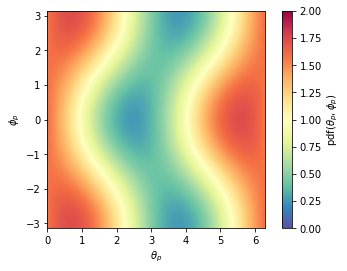

In [11]:
plt.imshow(ys,extent=[theta_min, theta_max,phi_min, phi_max], cmap='Spectral_r', origin='lower')
plt.clim(0,2)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

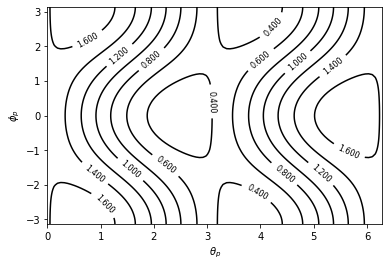

In [12]:
contours = plt.contour(theta_grid, phi_grid, ys, colors='k')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

# Event generation

In [13]:
class Generator:
    
    def __init__(self,
        event_number: int, 
        random_state: int = 2022
    ):
        self._event_number = event_number
        self._random_state = random_state
        random.seed(random_state)
    
    ## Getter and setter methods
    @property
    def event_number(self) -> int:
        return self._event_number
    
    @event_number.setter
    def event_number(self, n) -> None:
        self._event_number = n
    
    @property
    def random_state(self) -> int:
        return self._random_state
    
    @random_state.setter
    def random_state(self, n) -> None:
        self._random_state = n
        random.seed(n)
        
    ## Individual generators
    def generate_omega(self) -> Tuple[float]:
        pdf_min = 0
        pdf_max = 2
                
        accept = False
        while accept is not True:
            theta = random.uniform(0,2*np.pi)
            phi = random.uniform(-np.pi,np.pi)
            yref = random.uniform(pdf_min, pdf_max)
            
            if yref <= pdf(theta, phi):
                accept = True
        
        return theta, phi
    
    ## For now it's very simplified: lambda momentum along z, maximal polarization s0 = 1, g=1.226, Dy = 4 T m, beta= 1
    def generate_event(self) -> dict:
        own_vertex = [0,0, random.uniform(0,1000)]
        momentum = [0,0,random.uniform(0,10000)]
        decay_length = random.uniform(0,5000)
        
        end_vertex = [
            random.uniform(-1000,1000),
            random.uniform(-1000,1000),
            random.uniform(5500,8500)
        ]
        
        theta, phi = self.generate_omega()
        
        event_dict = {
            'L_OWNVERTEX_X': own_vertex[0],
            'L_OWNVERTEX_Y': own_vertex[1],
            'L_OWNVERTEX_Z': own_vertex[2],
            'L_PX': momentum[0],
            'L_PY': momentum[1],
            'L_PZ': momentum[2],
            'L_DECAYLENGTH': decay_length,
            'L_ENDVERTEX_X': end_vertex[0],
            'L_ENDVERTEX_Y': end_vertex[1],
            'L_ENDVERTEX_Z': end_vertex[2],
            'THETA': theta,
            'PHI': phi
        }
        
        return event_dict
    
    def generate_sample(self) -> pd.DataFrame:
        events = []
        
        for i in range(self._event_number):
            events.append(self.generate_event())
        
        df = pd.DataFrame(events)
        
        return df

In [14]:
pseudo_experiment_generator = Generator(100000, random_state=2021)
df_generated = pseudo_experiment_generator.generate_sample()
df_generated

,L_OWNVERTEX_X,L_OWNVERTEX_Y,L_OWNVERTEX_Z,L_PX,L_PY,L_PZ,L_DECAYLENGTH,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,THETA,PHI
0,0,0,836.337502,0,0,8583.024042,2720.551650,-505.335333,270.041183,8420.895564,2.984742,2.596495
1,0,0,829.550527,0,0,7432.948284,3368.925665,95.683549,-898.001886,7979.710184,2.485044,-2.433953
2,0,0,983.102862,0,0,4425.830206,578.889163,84.715847,-72.806918,6348.350858,0.857329,-3.110717
3,0,0,884.827839,0,0,1948.291120,851.010786,621.912468,-197.617286,7244.148716,2.312839,2.024806
4,0,0,76.583766,0,0,1749.507255,2925.456891,395.642373,158.067258,7389.749958,5.853460,-0.646478
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,62.215163,0,0,4499.819134,3019.236022,425.848408,-11.527129,8302.938970,5.596964,-0.795276
99996,0,0,896.817767,0,0,3198.527049,2367.261921,-178.277184,-695.789444,8281.033212,5.832320,-2.205333
99997,0,0,187.026864,0,0,6432.555457,1459.849895,801.048417,297.866538,7102.338678,1.075876,-3.066130
99998,0,0,821.699608,0,0,7808.619032,3301.984294,826.924620,934.833538,5563.776005,6.179510,-0.011674


# Analysis of generated events

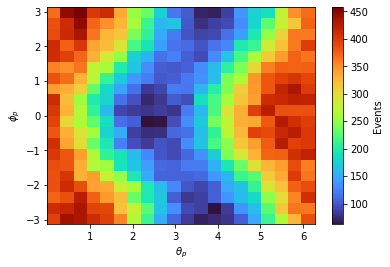

In [15]:
plt.hist2d(df_generated['THETA'], df_generated['PHI'], cmap='turbo', bins=20)
plt.colorbar(label='Events')
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

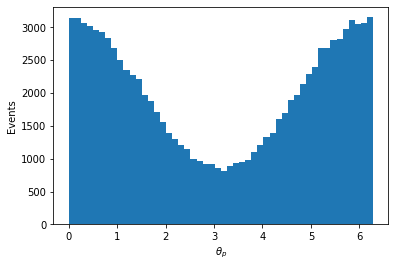

In [16]:
plt.hist(df_generated['THETA'],bins=50)
plt.xlabel(r"$\theta_p$")
plt.ylabel("Events")
plt.show()

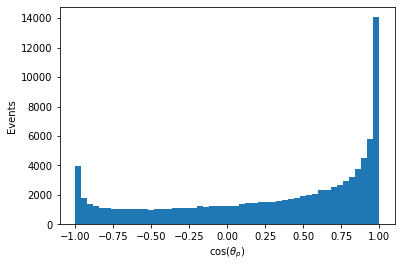

In [17]:
plt.hist(np.cos(df_generated['THETA']),bins=50)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")
plt.show()

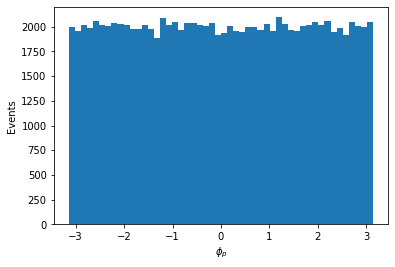

In [18]:
plt.hist(df_generated['PHI'],bins=50)
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")
plt.show()

# Fit of events

In [19]:
def function_for_fit(xdata: np.array, S: float, g: float) -> float:
    theta, phi = xdata
    return S * pdf(theta, phi, g=g)

In [20]:
fit_func = {
     'param_names' : [r'S',  r'g'],
     'p0'          : [1000,   1.2],
     'lb'          : [10,     1.1],
     'ub'          : [100000, 1.3]
}

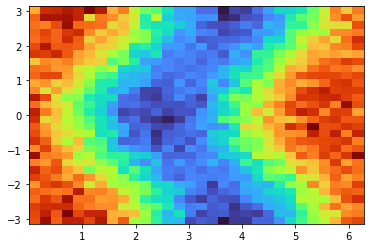

In [21]:
evt_number, theta_edges, phi_edges, _ = plt.hist2d(df_generated['THETA'], df_generated['PHI'], cmap='turbo', bins=30)

In [22]:
theta_midpoints = (theta_edges[:-1] + theta_edges[1:])/2
theta_midpoints

array([0.10471877, 0.3141563 , 0.52359383, 0.73303136, 0.94246889,
       1.15190642, 1.36134395, 1.57078148, 1.78021901, 1.98965654,
       2.19909407, 2.4085316 , 2.61796913, 2.82740666, 3.03684419,
       3.24628172, 3.45571925, 3.66515678, 3.87459431, 4.08403184,
       4.29346938, 4.50290691, 4.71234444, 4.92178197, 5.1312195 ,
       5.34065703, 5.55009456, 5.75953209, 5.96896962, 6.17840715])

In [23]:
phi_midpoints = (phi_edges[:-1] + phi_edges[1:])/2
phi_midpoints

array([-3.03679414, -2.82735803, -2.61792193, -2.40848582, -2.19904972,
       -1.98961362, -1.78017751, -1.57074141, -1.3613053 , -1.1518692 ,
       -0.94243309, -0.73299699, -0.52356088, -0.31412478, -0.10468868,
        0.10474743,  0.31418353,  0.52361964,  0.73305574,  0.94249185,
        1.15192795,  1.36136406,  1.57080016,  1.78023626,  1.98967237,
        2.19910847,  2.40854458,  2.61798068,  2.82741679,  3.03685289])

In [24]:
theta_grid_data, phi_grid_data = np.meshgrid(theta_midpoints, phi_midpoints)

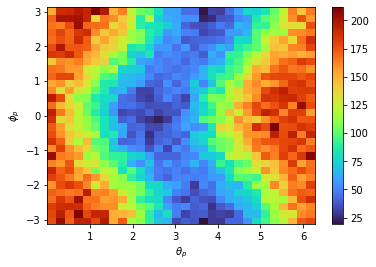

In [25]:
plt.pcolormesh(theta_grid_data, phi_grid_data, evt_number.T, cmap='turbo', shading='auto')
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.colorbar()
plt.show()

In [26]:
evt_number.shape

(30, 30)

In [27]:
xdata = np.vstack((theta_grid_data.ravel(), phi_grid_data.ravel()))

In [28]:
xdata.shape

(2, 900)

In [29]:
ydata = evt_number.T.ravel()

In [30]:
ydata.shape

(900,)

In [31]:
param_best, param_covmatrix = optimize.curve_fit(
    f=function_for_fit,
    xdata=xdata,
    ydata=ydata,
    p0=fit_func['p0'],
    sigma=np.sqrt(ydata),
    bounds=(
        fit_func['lb'],
        fit_func['ub']
    )
)

In [32]:
def pdg_round(value, error) :
    "Given a value and an error, round and format them according to the PDG rules for significant digits"
    def three_digits(value) :
        "extract the three most significant digits and return them as an int"
        return int(("%.2e"%float(error)).split('e')[0].replace('.','').replace('+','').replace('-',''))
    def n_significant_digits(three_digits) :
        assert three_digits<1000,"three digits (%d) cannot be larger than 10^3"%three_digits
        if three_digits<101 : return 2 # not sure
        elif three_digits<356 : return 2
        elif three_digits<950 : return 1
        else : return 2
    def frexp10(value) :
        "convert to mantissa+exp representation (same as frex, but in base 10)"
        valueStr = ("%e"%float(value)).split('e')
        return float(valueStr[0]), int(valueStr[1])
    def n_digits_value(expVal, expErr, nDigitsErr) :
        "compute the number of digits we want for the value, assuming we keep nDigitsErr for the error"
        return expVal-expErr+nDigitsErr
    def format_value(value, exponent, nDigits, extraRound=0) :
        "Format the value; extraRound is meant for the special case of three_digits>950"
        roundAt = nDigits-1-exponent - extraRound
        nDec = roundAt if exponent<nDigits else 0
        nDec = max([nDec, 0])
        return ('%.'+str(nDec)+'f')%round(value,roundAt)
    tD = three_digits(error)
    nD = n_significant_digits(tD)
    expVal, expErr = frexp10(value)[1], frexp10(error)[1]
    extraRound = 1 if tD>=950 else 0
    return (format_value(value, expVal, n_digits_value(expVal, expErr, nD), extraRound),
            format_value(error,expErr, nD, extraRound))

In [33]:
param_names = fit_func['param_names']
param_error = np.sqrt(np.diag(param_covmatrix))
for name, best, error in zip(param_names, param_best, param_error):
    best_rounded, error_rounded = pdg_round(best, error)
    print(name, ": ", best_rounded, " +- ", error_rounded)

S :  110.16  +-  0.34
g :  1.219  +-  0.012
